In [148]:
%matplotlib inline
import os
import re
import numpy as np
import random
import tarfile
import urllib
import torch
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
from glob import glob
import collections

In [67]:
class FishDataset(Dataset):
    """Fishes dataset."""
    
    def __init__(self, root_dir, transform=None, target_transform=None, download=False):
        """
        Args:
            root_dir (string): Data directory containing the fish_image and mask_image folders.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root_dir = os.path.abspath(root_dir)
        self.transform = transform
        self.target_transform = target_transform
        
        if download:
            self.download()

        if not self._check_exists():
            raise RuntimeError('Dataset not found. You can use download=True to download it.')
        
        
        self.images = glob(os.path.join(root_dir, 'fish_image/*/*.png'))
        self.masks = [re.sub('fish', 'mask', image) for image in self.images]
        self.labels = [int(re.search('.*fish_image/fish_(\d+)', image).group(1)) for image in self.images]
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        label = self.labels[index]
        image = Image.open(self.images[index])
        mask = Image.open(self.masks[index])
        
        # https://github.com/pytorch/vision/issues/9
        seed = np.random.randint(2147483647)
        random.seed(seed)
        if self.transform is not None:
            image = self.transform(image)
        
        random.seed(seed)
        if self.target_transform is not None:
            mask = self.target_transform(mask)
            
        return (image, mask, label)
    
    
    def download(self):
        if self._check_exists():
            return
        
        try:
            os.makedirs(self.root_dir)
        except FileExistsError:
            pass
        
        url = 'http://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar'
        file_path = os.path.join(self.root_dir, 'fishRecognition_GT.tar')
        print('Downloading...', end=' ')
        urllib.request.urlretrieve(url, file_path)
        print('Done!')
        print('Extracting files...', end=' ')
        with tarfile.open(file_path) as tar:
                tar.extractall(self.root_dir)
        os.remove(file_path)
        print('Done!')
        
    def _check_exists(self):
        return os.path.exists(os.path.join(self.root_dir, 'fish_image')) and \
               os.path.exists(os.path.join(self.root_dir, 'mask_image'))

In [71]:
transform = transforms.Compose([
    transforms.Resize(size=(100,100)),
    transforms.RandomHorizontalFlip(),
    #transforms.ToTensor()
])

In [170]:
img


   0
   0
   0
 ⋮  
   0
   0
   0
[torch.ByteTensor of size 1300]

In [72]:
fish = FishDataset('../data2', transform=transform, target_transform=transform)

In [91]:
image, mask, label = fish[17]

In [ ]:
mask.tobytes()

In [174]:
len(mask.tobytes())

1300

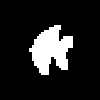

In [161]:
Image.frombytes('1', (100,100), mask.tobytes())